## Data Visualization of Kiva NGO data

[Kiva.org](https://www.kiva.org/) is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world by accepting donations online. Anybody of us can donate $ 1, $ 100 or $ 10000 sitting at home.

**Aim** of this analysis is: Use Data Visualization to locate those regions which need to be prioritized for funding because they are more economically backward than other regions. Kiva provided loan & region data, finding appropriate economical and financial data & connecting it to the loan & region data was a **part of the problem**

Summary of my approach:

1. I started with initial EDA of various information in the dataset
2. Phillipines was the country which had most of the loans so I decided to focus on it
3. Found some economic indicators for Philippines
4. Data **lot of data cleaning** to connect the external data and loan data
5. Used the combined data to locate a few regions where loan flow can be prioritized due to poverty

Tools used: R, ggplot2 and other miscellaneous helper packages for data visualization

## Notebook 1 - Loan Characteristics in different contintents

* load data
* call packages
* join loans data with continent-country mappings

In [1]:
# supress warnings globally
options(warn=-1)

# read in the data
kiva_loans <- read.csv("kiva_loans.csv", header=T)
kiva_regions <- read.csv("kiva_mpi_region_locations.csv", header=T)
loan_theme_ids <- read.csv("loan_theme_ids.csv", header=T)
loan_theme_regions <- read.csv("loan_themes_by_region.csv", header=T)

# External file containing country-continent mappings
continent <- read.csv("countryContinent.csv", header=T)

library(dplyr)
library(ggplot2)
library(moments)
library(gridExtra)
library(repr)

kiva_loans$country <- as.character(kiva_loans$country)
continent$country <- as.character(continent$country)

kiva_loans_new <- left_join(kiva_loans, continent, by = "country")
kiva_loans_new$continent <- addNA(kiva_loans_new$continent)
levels(kiva_loans_new$continent)[7] <- "North America"


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



### Distribution of loan amounts accross continents

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


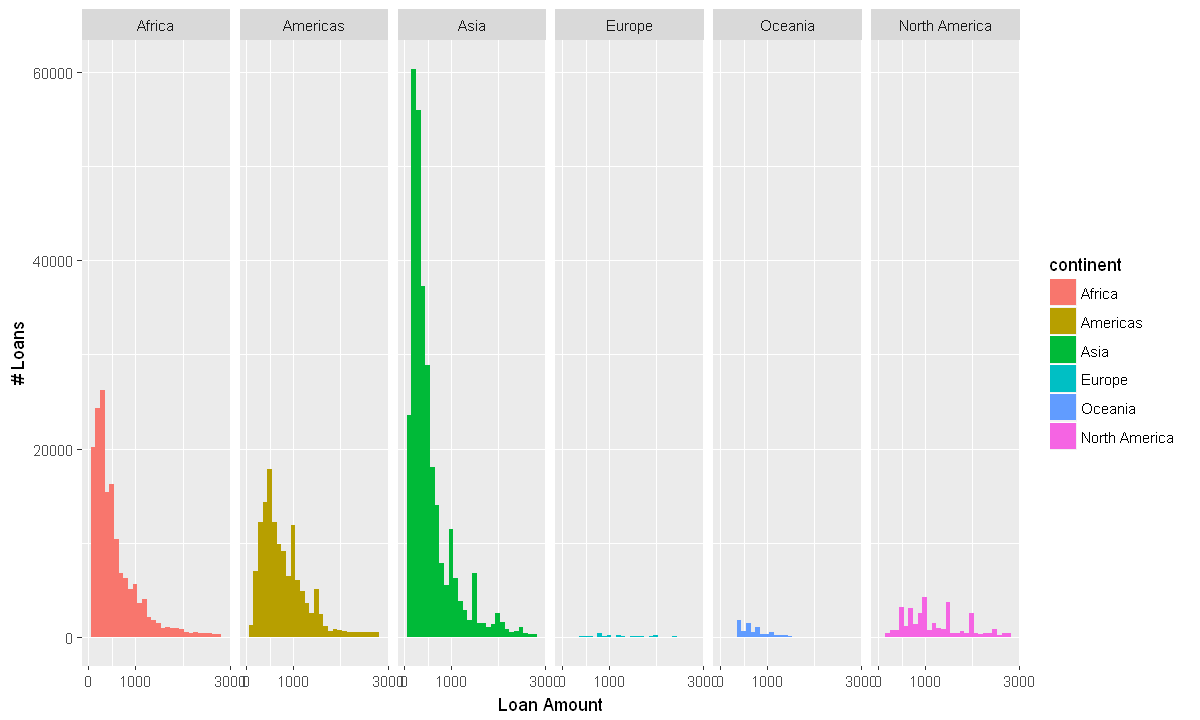

In [2]:
# DISTRIBUTION OF LOAN AMOUNTS accross CONTINENTS
Loans_by_continent <- ggplot(data = kiva_loans_new, aes(x = loan_amount, fill = continent)) + 
                  geom_histogram() + facet_grid(.~continent) +
              scale_x_continuous("Loan Amount", limits = c(0,quantile(kiva_loans_new$loan_amount, .95)),
                                        breaks = c(0,1000, 3000)) +
                                    scale_y_continuous("# Loans")

options(repr.plot.width=10, repr.plot.height=6)
plot(Loans_by_continent)

* The plot above shows the histograms of top 95% (in an effort to exclude outliers) sorted values of Loan Amount split by Continents.
* We can see that since the distribution in AMERICAS, AFRICA and ASIA is +ve skwewed, people in these regions comprise mostly of Small Borrowers.
* This indicates that people in this region might be in more need of welfare than other 3 continents. Not in all cases though but definitely with respect to overall proportion.

### Skewness of loan amount in various continents

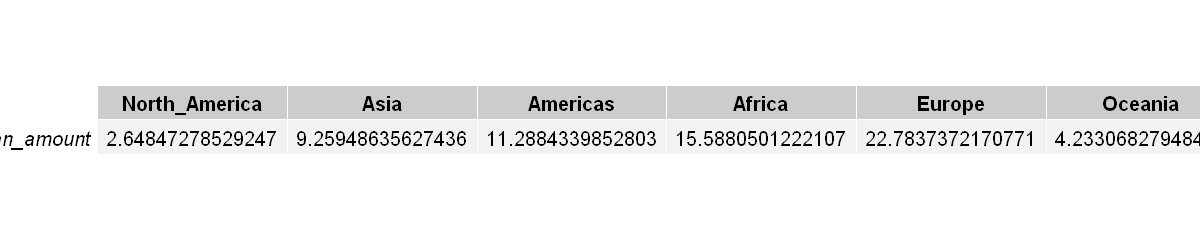

In [3]:
# Lets see how skewed they are

skewness_check <- data.frame(
          North_America = skewness(kiva_loans_new %>%
                         filter(continent == "North America") %>%
                         select(loan_amount)),
          Asia = skewness(kiva_loans_new %>%
                          filter(continent == "Asia") %>%
                          select(loan_amount)),
          Americas = skewness(kiva_loans_new %>%
                            filter(continent == "Americas") %>%
                            select(loan_amount)),
          Africa = skewness(kiva_loans_new %>%
                              filter(continent == "Africa") %>%
                              select(loan_amount)),
          Europe = skewness(kiva_loans_new %>%
                              filter(continent == "Europe") %>%
                              select(loan_amount)),
          Oceania = skewness(kiva_loans_new %>%
                              filter(continent == "Oceania") %>%
                              select(loan_amount))
)


options(repr.plot.width=10, repr.plot.height=2)
grid.table(skewness_check)

* We can see that the skewness for NA is way too less than other areas
* The skewness of Africa, Americas and Asia is high as expected
* This overall analysis implies that loans in Asia, AM and AF is dominated by smaller loan amounts



* *Hence for poverty analysis we might want to focus on these continents first*

### Looking at loan terms vs. continents

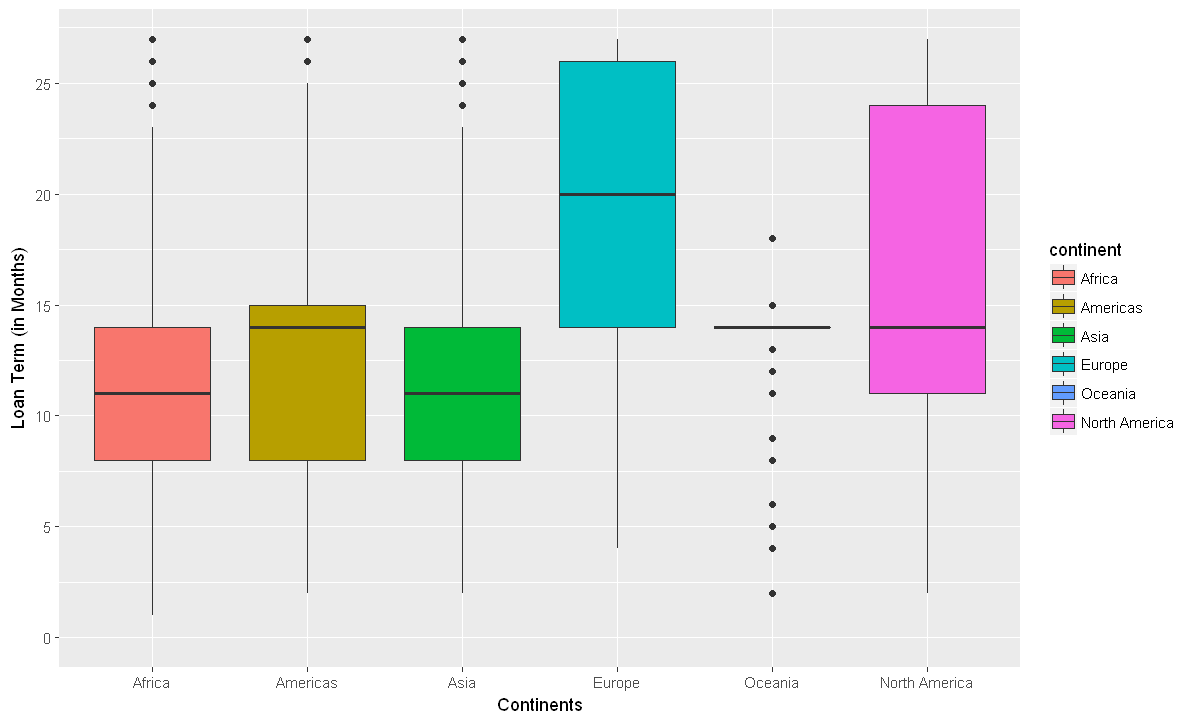

In [4]:
# Boxplots of Loan term in months split by continent after removing outliers
term_boxplots_continent <- ggplot(data = kiva_loans_new, 
                                  aes(x = continent, y = term_in_months, fill = continent)) +
  geom_boxplot() +
  scale_y_continuous("Loan Term (in Months)", limits = c(0,quantile(kiva_loans_new$term_in_months, .95)),
                     breaks = c(0,5,10,15,20,25))+
  scale_x_discrete("Continents")


options(repr.plot.width=10, repr.plot.height=6)
plot(term_boxplots_continent)

* Europe and NA have a) higher loan terms b) well distributed loan amounts
* Potential hypothesis: Most people in these areas take high amount loans and hence pay them slowly

### Looking at the relationship between Loan Term and Loan Amount in different continents

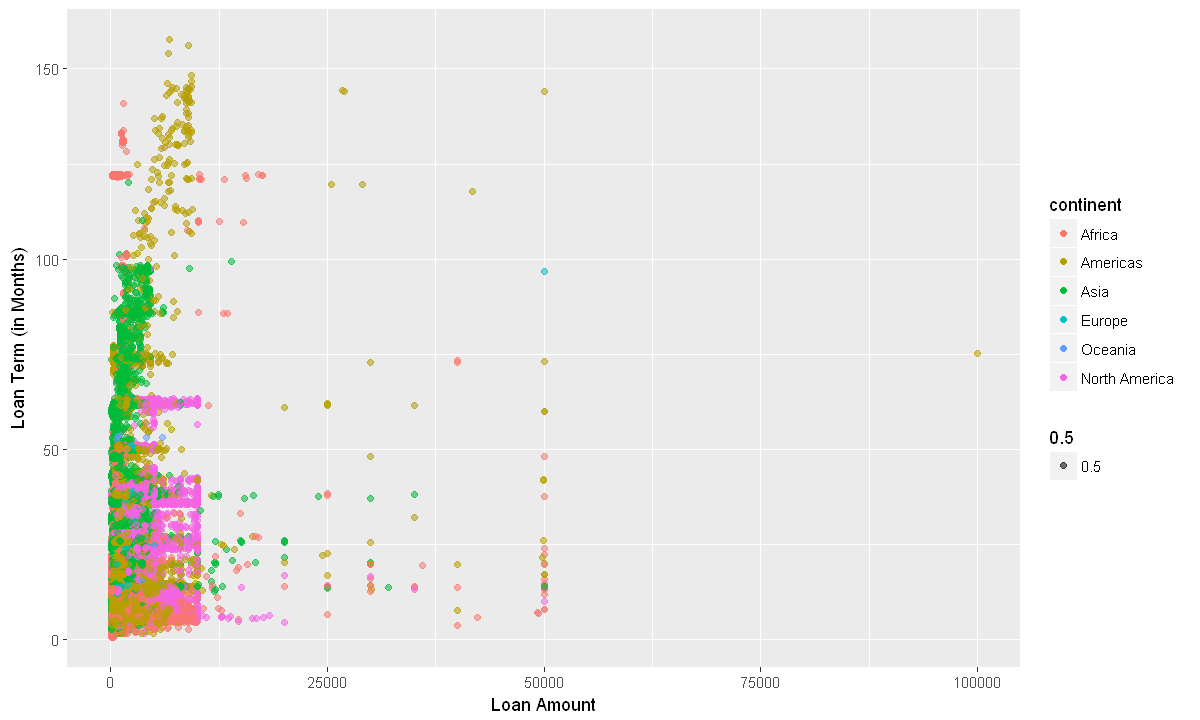

In [5]:
LoanAmt_term_continent <- ggplot(data = kiva_loans_new, aes(x = loan_amount, y = term_in_months, col = continent, alpha = 0.5)) + 
          geom_jitter() +
          scale_x_continuous("Loan Amount") +
          scale_y_continuous("Loan Term (in Months)")

plot(LoanAmt_term_continent)

* This plot shows a 2-D plot of Amounts vs. Term (in months)
* We can see that Asian people are Small borrowers as well as slow payers
* North Americans on the other hand are moderate borrowers and fairly fast payers
* People in Americas are Small borrowers like asians but their payment duration is mostly spread all over the range of the Loan term. There are fast payers, moderate ones as well as slow payers


### Proportion of loans per continent

In [16]:
prop.table(table(kiva_loans_new$continent))*100


                     Africa      Americas          Asia        Europe 
    0.0000000    24.5446622    21.9768923    45.0319947     0.4316118 
      Oceania North America 
    1.1851819     6.8296571 

* Africa ~ 24% of loans
* Americas ~ 22% of loans
* Asia ~ 45% of loans

### The same plot from above focusing only on "Lesser amount continents"

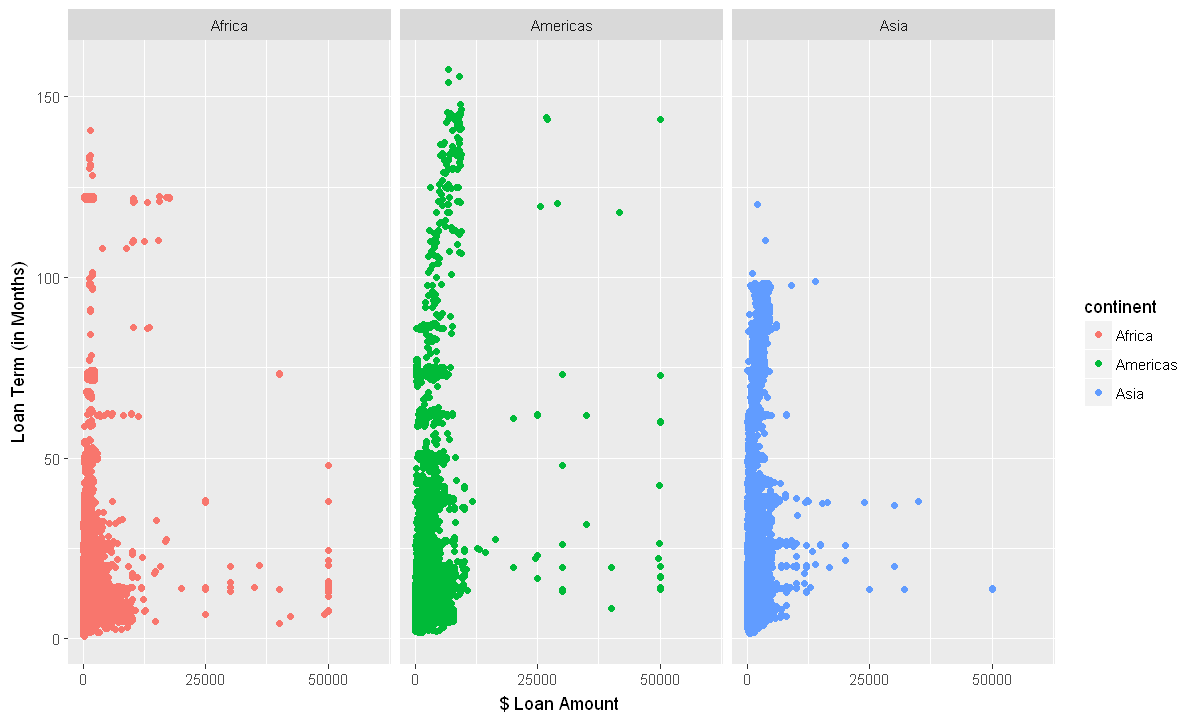

In [6]:
LoanAmt_term_top3 <- ggplot(
            data = kiva_loans_new %>% filter(continent %in% c("Americas", "Africa", "Asia")),
            aes(x = loan_amount, y = term_in_months, col = continent)) +
            geom_jitter() +
            facet_grid(.~continent)+
            scale_x_continuous(name = "$ Loan Amount ", limits = c(0, 60000),breaks = c(0,25000,50000)) +
            scale_y_continuous(name = "Loan Term (in Months)")


plot(LoanAmt_term_top3)

* There is a small cluster for Americas and Africa of High borrowers and fast payers. This cluster is almost absent for Asia.
* The LOAN_AMOUNT range (thickness) of the vertical blue line cluster for Asia is smaller than that of Africa and Americas i.e. the people here are borrowing lesser amounts if compares on a bigger picture than those in Americas and Africa
* Americas interestingly has a cluster (see top left of the plot) consisting of small borrowers and slow payers which is absent in Asia and Africa.
* We will further explore this Loan amount vs. Loan term relationship at a more granular level in the following plots.